In [ ]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import json
from pprint import pprint

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

!pip install emoji
!pip install contractions
# Text processing libraries
import emoji
import re
import contractions
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from wordcloud import WordCloud

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

     |████████████████████████████████| 168 kB 4.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=f1e2eefa708874e6a2126d438412715fe5f6fbfb048bb8f49b6f02f06e6c9fc3
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji
     |████████████████████████████████| 284 kB 2.7 MB/s 
     |████████████████████████████████| 321 kB 48.7 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85445 sha256=7dee35a75b9dc71f4ff6633e7991b6dcc23287cdf52fb46a3596dcdf50ef6069
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Importing raw comments and labels
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/train.tsv', sep='\t', header=None, names=['Text', 'Lable', 'Id']).drop('Id', axis=1)
df_val   = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/dev.tsv'  , sep='\t', header=None, names=['Text', 'Lable', 'Id']).drop('Id', axis=1)
df_test  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/test.tsv' , sep='\t', header=None, names=['Text', 'Lable', 'Id']).drop('Id', axis=1)

df_train.head()

,Text,Lable
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [ ]:
# Defineing the number of samples in train, validation and test dataset
size_train = df_train.shape[0]
size_val = df_val.shape[0]
size_test = df_test.shape[0]
print("Train:", size_train)
print("Validation:", size_val)
print("Test:", size_test)
print("All data: ", size_train + size_val + size_test)

Train: 43410
Validation: 5426
Test: 5427
All data:  54263


In [ ]:
#################################################### LABLE PROCESSING

In [ ]:
# Concatenating the 3 datasets for preprocessing
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index(drop=True)
df_all.head()

,Text,Lable
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [ ]:
# Display DataFrame information
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54263 entries, 0 to 54262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    54263 non-null  object
 1   Lable   54263 non-null  object
dtypes: object(2)
memory usage: 848.0+ KB


In [ ]:
# Loading emotion labels
with open("/content/drive/MyDrive/Colab Notebooks/Data/emotions.txt", "r") as file:
  Lable_names = file.read().split("\n")

for lable in Lable_names:
  print(lable, end=', ')

print("\n\nNumber of lables: {} (with 'neutral')".format(len(Lable_names)))

admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise, neutral, 

Number of lables: 28 (with 'neutral')


In [ ]:
# Convertings emotion lables into list of lables
df_all['Lable'] = df_all['Lable'].apply(lambda x: x.split(','))

# Preview of data
display(df_all.head())

,Text,Lable
0,My favourite food is anything I didn't have to...,[27]
1,"Now if he does off himself, everyone will thin...",[27]
2,WHY THE FUCK IS BAYLESS ISOING,[2]
3,To make her feel threatened,[14]
4,Dirty Southern Wankers,[3]


In [ ]:
# Defining a function that maps each index to emotion labels
def indexToEL(index_list):
  lable_list = []
  for i in index_list:
    lable_list.append(Lable_names[int(i)])
  return lable_list

# Applying the function
df_all['Lable'] = df_all['Lable'].apply(indexToEL)

# Preview of data
display(df_all.head())

,Text,Lable
0,My favourite food is anything I didn't have to...,[neutral]
1,"Now if he does off himself, everyone will thin...",[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[anger]
3,To make her feel threatened,[fear]
4,Dirty Southern Wankers,[annoyance]


In [ ]:
# OneHot encoding for multi-label classification
for emo in Lable_names:
  df_all[emo] = np.zeros((len(df_all),1))
  df_all[emo] = df_all['Lable'].apply(lambda x: 1 if emo in x else 0)

# Delete Lable column
df_all = df_all.drop(['Lable'], axis=1)

# Preview of data
display(df_all.head())

,Text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#################################################### TEXT PROCESSING

In [ ]:
# neme_entity = en_core_web_sm.load()

In [ ]:
# Building a preprocessing function to clean text
def preprocess_corpus(x):

  # Adding a space between words and punctation
  x = re.sub( r'([a-zA-Z\[\]])([,;.!?])', r'\1 \2', x)
  x = re.sub( r'([,;.!?])([a-zA-Z\[\]])', r'\1 \2', x)

  # Demojize
  x = emoji.demojize(x)

  # Expand contraction
  x = contractions.fix(x)

  # Lower
  x = x.lower()

  #correct some acronyms/typos/abbreviations
  x = re.sub(r"lmao", "laughing my ass off", x)
  x = re.sub(r"amirite", "am i right", x)
  x = re.sub(r"\b(tho)\b", "though", x)
  x = re.sub(r"\b(ikr)\b", "i know right", x)
  x = re.sub(r"\b(ya|u)\b", "you", x)
  x = re.sub(r"\b(eu)\b", "europe", x)
  x = re.sub(r"\b(da)\b", "the", x)
  x = re.sub(r"\b(dat)\b", "that", x)
  x = re.sub(r"\b(dats)\b", "that is", x)
  x = re.sub(r"\b(cuz)\b", "because", x)
  x = re.sub(r"\b(fkn)\b", "fucking", x)
  x = re.sub(r"\b(tbh)\b", "to be honest", x)
  x = re.sub(r"\b(tbf)\b", "to be fair", x)
  x = re.sub(r"faux pas", "mistake", x)
  x = re.sub(r"\b(btw)\b", "by the way", x)
  x = re.sub(r"\b(bs)\b", "bullshit", x)
  x = re.sub(r"\b(kinda)\b", "kind of", x)
  x = re.sub(r"\b(bruh)\b", "bro", x)
  x = re.sub(r"\b(w/e)\b", "whatever", x)
  x = re.sub(r"\b(w/)\b", "with", x)
  x = re.sub(r"\b(w/o)\b", "without", x)
  x = re.sub(r"\b(doj)\b", "department of justice", x)

  #replace some words with multiple occurences of a letter, example "coooool" turns into --> cool
  x = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", x)
  x = re.sub(r"\b(co+l+)\b", "cool", x)
  x = re.sub(r"\b(g+o+a+l+)\b", "goal", x)
  x = re.sub(r"\b(s+h+i+t+)\b", "shit", x)
  x = re.sub(r"\b(o+m+g+)\b", "omg", x)
  x = re.sub(r"\b(w+t+f+)\b", "wtf", x)
  x = re.sub(r"\b(w+h+a+t+)\b", "what", x)
  x = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", x)
  x = re.sub(r"\b(w+o+w+)\b", "wow", x)
  x = re.sub(r"\b(w+h+y+)\b", "why", x)
  x = re.sub(r"\b(s+o+)\b", "so", x)
  x = re.sub(r"\b(f)\b", "fuck", x)
  x = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", x)
  x = re.sub(r"\b(ofc)\b", "of course", x)
  x = re.sub(r"\b(the us)\b", "usa", x)
  x = re.sub(r"\b(gf)\b", "girlfriend", x)
  x = re.sub(r"\b(hr)\b", "human ressources", x)
  x = re.sub(r"\b(mh)\b", "mental health", x)
  x = re.sub(r"\b(idk)\b", "i do not know", x)
  x = re.sub(r"\b(gotcha)\b", "i got you", x)
  x = re.sub(r"\b(y+e+p+)\b", "yes", x)
  x = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", x)
  x = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", x)
  x = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", x)
  x = re.sub(r"\b(o+h+)\b", "oh", x)
  x = re.sub(r"\b(a+h+)\b", "ah", x)
  x = re.sub(r"\b(u+h+)\b", "uh", x)

  # Handling emojis
  x = re.sub(r"<3", " love ", x)
  x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
  x = re.sub(r":\)", " smiling_face ", x)
  x = re.sub(r"^_^", " smiling_face ", x)
  x = re.sub(r"\*_\*", " star_struck ", x)
  x = re.sub(r":\(", " frowning_face ", x)
  x = re.sub(r":\^\(", " frowning_face ", x)
  x = re.sub(r";\(", " frowning_face ", x)
  x = re.sub(r":\/",  " confused_face", x)
  x = re.sub(r";\)",  " wink", x)
  x = re.sub(r">__<",  " unamused ", x)
  x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
  x = re.sub(r"\b(n+a+h+)\b", "no", x)

  # Handling special cases of text
  x = re.sub(r"h a m b e r d e r s", "hamberders", x)
  x = re.sub(r"b e n", "ben", x)
  x = re.sub(r"s a t i r e", "satire", x)
  x = re.sub(r"y i k e s", "yikes", x)
  x = re.sub(r"s p o i l e r", "spoiler", x)
  x = re.sub(r"thankyou", "thank you", x)
  x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

  # Remove special characters and numbers replace by space + remove double space
  x = re.sub(r"\b([.]{3,})"," dots ", x)
  x = re.sub(r"[^A-Za-z!?_]+"," ", x)
  x = re.sub(r"\b([s])\b *","", x)
  x = re.sub(r" +"," ", x)

  # name entity
  # n_e = neme_entity(x)
  # n_e = list(map(str, list(n_e.ents)))

  # # Lemmatization
  lemmatizer = WordNetLemmatizer()
  filter_words = ['name']
  # stop_words = set(stopwords.words('english'))
  # negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except', 'even though', 'yet']
  # stop_words = [z for z in stop_words if z not in negative]
  # preprocessed_tokens = [lemmatizer.lemmatize(temp) for temp in x.split() if temp not in (filter_words + stop_words + n_e)]
  preprocessed_tokens = [lemmatizer.lemmatize(temp) for temp in x.split() if temp not in filter_words]
  x = ' '.join([pt for pt in preprocessed_tokens]).strip()

  return x

In [ ]:
# Applying the preprocessing function on the dataset
df_all["Clean_text"] = df_all["Text"].apply(preprocess_corpus)

# Preview of data
display(df_all[['Text', 'Clean_text']].sample(5))

In [ ]:
Dictionary_words = []
with open("/content/drive/MyDrive/Colab Notebooks/Data/words_alpha.txt", "r") as file:
  Dictionary_words = file.read().split("\n")

len(Dictionary_words)

370099

In [ ]:
datases_words = []
for index, row in df_all.iterrows():
  temp = row['Clean_text'].split()
  for word in temp:
    datases_words.append(word)
len(datases_words)

318582

In [ ]:
chertHa = []
for DSword in datases_words:
  if DSword not in Dictionary_words:
    chertHa.append(DSword)
len(chertHa)

30481

In [ ]:
chertHa_unique = []
for ch in chertHa:
  if ch not in chertHa_unique:
    if '!' not in ch and '?' not in ch:
      chertHa_unique.append(ch)
len(chertHa_unique)

6276

In [ ]:
with open("/content/drive/MyDrive/Colab Notebooks/Data/chertHa.txt", "w") as file:
  for element in chertHa_unique:
    file.write(element + "\n")

NameError: ignored

In [ ]:
# Dropping 'text' column
df_all = df_all[ ['Clean_text'] + [ col for col in df_all.columns if col not in ['Text', 'Clean_text'] ] ]

# Preview of data
display(df_all.head())

,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,now if he doe off himself everyone will think ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,to make her feel threatened,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,dirty southern wanker,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Building a function that will divide in train, validation and test sets
def get_train_val_test(df):
  train = df.iloc[:size_train, :]
  val = df.iloc[size_train:size_train+size_val, :]
  test = df.iloc[size_train+size_val:size_train+size_val+size_test, :]
  return train, val, test

# Dividing back in train, validation and test datasets (GoEmotions)
train_GE, val_GE, test_GE = get_train_val_test(df_all)
print(train_GE.shape)
print(val_GE.shape)
print(test_GE.shape)

(43410, 29)
(5426, 29)
(5427, 29)


In [ ]:
# del
# finding length of the longest sentence
train_GE['Clean_text'].str.len().max()

436

In [ ]:
# del
train_GE.Clean_text.groupby(pd.cut(train_GE.Clean_text.str.len(), np.arange(0,500,100))).count()

Clean_text
(0, 100]      42994
(100, 200]      250
(200, 300]        6
(300, 400]        1
Name: Clean_text, dtype: int64

In [ ]:
# del
train_GE = train_GE[train_GE.Clean_text.str.len()<=200]
train_GE = train_GE.reset_index(drop=True)
display(train_GE.shape)
display(train_GE['Clean_text'].str.len().max())

(43401, 29)

184

In [ ]:
# del_finalTest
# Do we have any duplicate rows?
duplicated_train = train_GE[(train_GE.duplicated(subset=['Clean_text']+Lable_names))].count()
display(duplicated_train)
duplicated_val = val_GE[(val_GE.duplicated(subset=['Clean_text']+Lable_names))].count()
display(duplicated_val)
duplicated_test = test_GE[(test_GE.duplicated(subset=['Clean_text']+Lable_names))].count()
display(duplicated_test)

Clean_text        1185
admiration        1185
amusement         1185
anger             1185
annoyance         1185
approval          1185
caring            1185
confusion         1185
curiosity         1185
desire            1185
disappointment    1185
disapproval       1185
disgust           1185
embarrassment     1185
excitement        1185
fear              1185
gratitude         1185
grief             1185
joy               1185
love              1185
nervousness       1185
optimism          1185
pride             1185
realization       1185
relief            1185
remorse           1185
sadness           1185
surprise          1185
neutral           1185
dtype: int64

Clean_text        88
admiration        88
amusement         88
anger             88
annoyance         88
approval          88
caring            88
confusion         88
curiosity         88
desire            88
disappointment    88
disapproval       88
disgust           88
embarrassment     88
excitement        88
fear              88
gratitude         88
grief             88
joy               88
love              88
nervousness       88
optimism          88
pride             88
realization       88
relief            88
remorse           88
sadness           88
surprise          88
neutral           88
dtype: int64

Clean_text        68
admiration        68
amusement         68
anger             68
annoyance         68
approval          68
caring            68
confusion         68
curiosity         68
desire            68
disappointment    68
disapproval       68
disgust           68
embarrassment     68
excitement        68
fear              68
gratitude         68
grief             68
joy               68
love              68
nervousness       68
optimism          68
pride             68
realization       68
relief            68
remorse           68
sadness           68
surprise          68
neutral           68
dtype: int64

In [ ]:
# del_finalTest
# remove duplicated
train_GE.drop_duplicates(subset=['Clean_text'], inplace=True)
val_GE.drop_duplicates(subset=['Clean_text'], inplace=True)
test_GE.drop_duplicates(subset=['Clean_text'], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Display dataSets shape
display(train_GE.shape)
display(val_GE.shape)
display(test_GE.shape)

(43410, 29)

(5426, 29)

(5427, 29)

In [ ]:
# Delete

# eliminate null value
# train_data = train_data[ ~(train_data.content_no_punctuation.isnull()) ]
# train_data = train_data.reset_index(drop=True)

In [ ]:
# Computing the number of labels for each sample
train_GE['Cardinality'] = train_GE.loc[:,Lable_names].apply(lambda x: sum(x), axis=1)

# Preview of data
display(train_GE.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,Cardinality
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,now if he doe off himself everyone will think ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,to make her feel threatened,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,dirty southern wanker,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Possible number of emotions per sample in our dataset
train_GE['Cardinality'].value_counts()

1    36308
2     6541
3      532
4       28
5        1
Name: Cardinality, dtype: int64

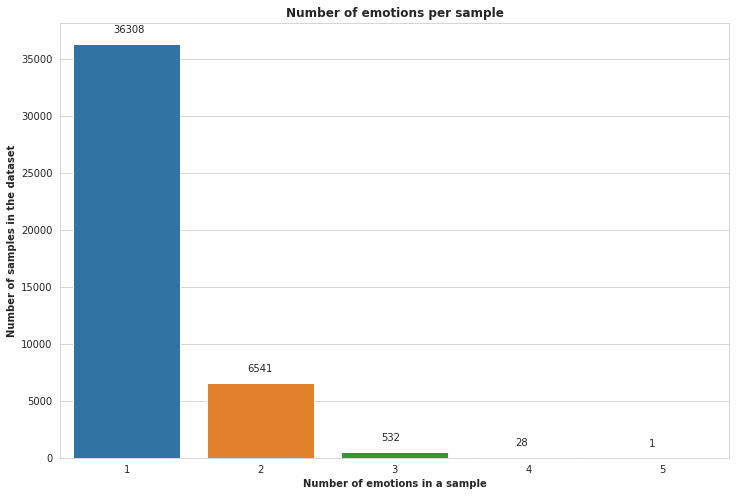

In [ ]:
# Possible number of emotions per sample in our dataset
plt.figure(figsize=(12,8))

ax = sns.countplot(x='Cardinality', data=train_GE)

for p in ax.patches:
  value = p.get_height()
  x = p.get_x() + p.get_width() - 0.5
  y = p.get_y() + p.get_height() + 1000
  ax.annotate(value, (x, y))


plt.title("Number of emotions per sample", fontweight='bold')
plt.ylabel("Number of samples in the dataset", fontweight='bold')
plt.xlabel("Number of emotions in a sample", fontweight='bold')
plt.show()

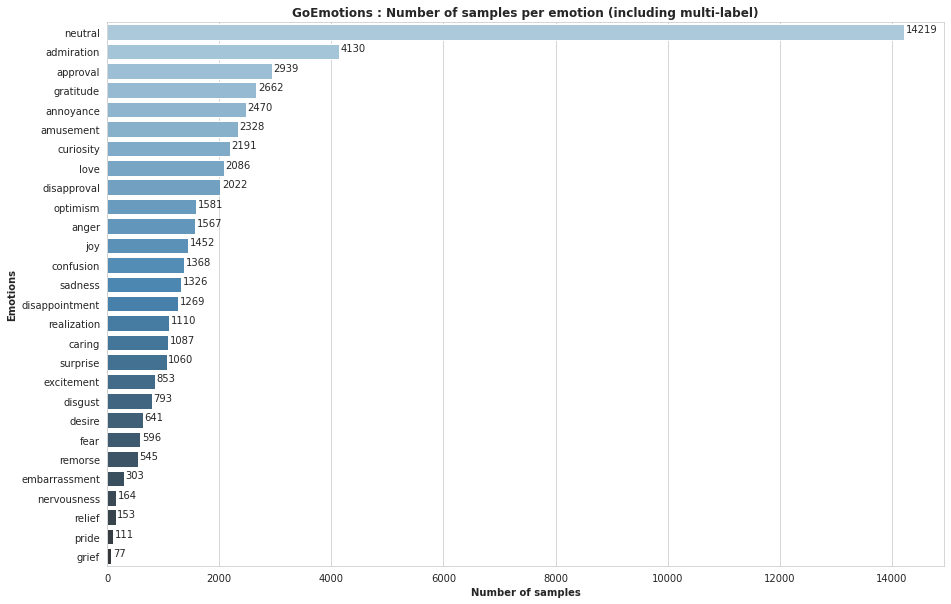

In [ ]:
# Computing number of samples per emotion
classes_GE_count = train_GE.loc[:,Lable_names].apply(lambda x: sum(x), axis=0).sort_values(ascending=False)

# Visualizing the number of samples per classes
plt.figure(figsize=(15,10))
ax = sns.barplot(x=classes_GE_count.values, y=classes_GE_count.index, orient='h', palette="Blues_d")

for p in ax.patches:
  value = int(p.get_width())
  x = p.get_x() + p.get_width() + 30
  y = p.get_y() + p.get_height()/2
  ax.annotate(value, (x, y))

plt.title("GoEmotions : Number of samples per emotion (including multi-label)", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Number of samples", fontweight='bold')
plt.show()

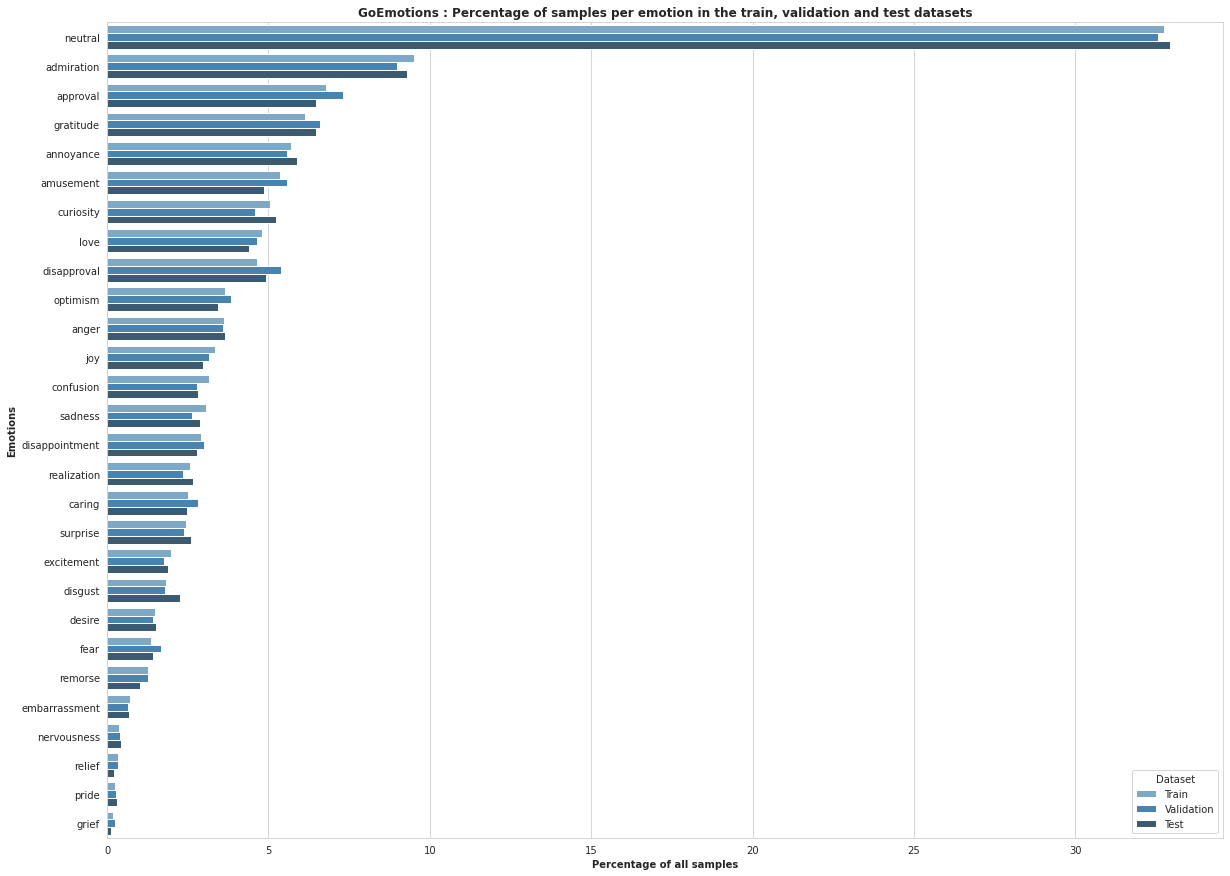

In [ ]:
size_train = train_GE.shape[0]
size_val = val_GE.shape[0]
size_test = test_GE.shape[0]

# Defining classes representation for each dataset (GoEmotions)
train_count_GE = (train_GE.loc[:, Lable_names].sum(axis=0) / size_train)*100
val_count_GE = (val_GE.loc[:, Lable_names].sum(axis=0) / size_val)*100
test_count_GE = (test_GE.loc[:, Lable_names].sum(axis=0) / size_test)*100

# Constructing a unique dataset for visualization purposes
balance_GE = pd.DataFrame(data=[train_count_GE, val_count_GE, test_count_GE]).T.reset_index(drop=False)
balance_GE.columns = ['Emotion', 'Train', 'Validation', 'Test']
balance_GE = balance_GE.sort_values('Train', ascending=False)
balance_GE = balance_GE.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train','Validation', 'Test'], value_name='Percentage')

# Classe Balance visualization on GoEmotions
plt.figure(figsize=(20,15))
sns.barplot(x='Percentage', y='Emotion', data=balance_GE, orient='h', hue='Dataset', palette="Blues_d")
plt.title("GoEmotions : Percentage of samples per emotion in the train, validation and test datasets", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Percentage of all samples", fontweight='bold')
plt.show()

In [ ]:
# Computing the number of words per sample
train_GE['Nb_words'] = train_GE['Clean_text'].apply(lambda x: len(x.split()))

# Preview of data
display(train_GE.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Clean_text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,Cardinality,Nb_words
0,my favourite food is anything i did not have t...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,12
1,now if he doe off himself everyone will think ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,20
2,why the fuck is bayless isoing,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6
3,to make her feel threatened,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
4,dirty southern wanker,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3


In [ ]:
train_GE['Nb_words'].max()

48

In [ ]:
train_GE.Nb_words.groupby(pd.cut(train_GE.Nb_words, np.arange(0,50,10))).count()

Nb_words
(0, 10]     16653
(10, 20]    18645
(20, 30]     8071
(30, 40]       26
Name: Nb_words, dtype: int64

In [ ]:
# Delete if ....

train_GE = train_GE[train_GE.Nb_words<=20]
train_GE = train_GE.reset_index(drop=True)
display(train_GE.shape)
display(train_GE['Nb_words'].max())

(43403, 31)

20

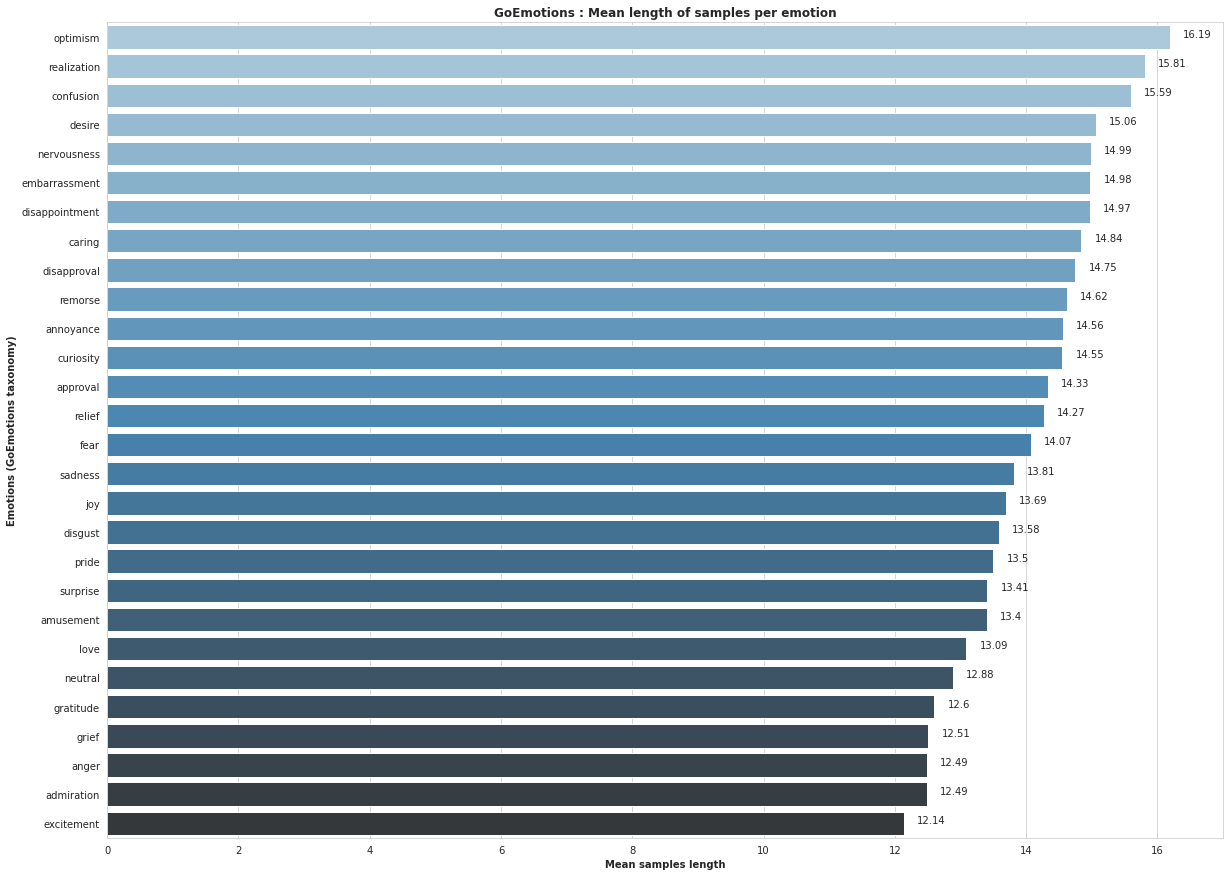

In [ ]:
# Computing the mean number of words per emotion
mean_nb_words = {}
for emo in Lable_names:
  nb = train_GE['Nb_words'].loc[train_GE[emo]==1].mean()
  mean_nb_words[emo] = round(nb,2)

# Putting it in a Dataframe
df_length_GE = pd.DataFrame.from_dict(mean_nb_words, orient='index')
df_length_GE.columns = ['Mean_length']
df_length_GE.sort_values('Mean_length', ascending=False, inplace=True)

# Visualizing the mean length of samples per emotion
plt.figure(figsize=(20,15))

ax = sns.barplot(x=df_length_GE['Mean_length'], y=df_length_GE.index, orient='h', palette="Blues_d")
for p in ax.patches:
  value = p.get_width()
  x = p.get_x() + p.get_width() + 0.2
  y = p.get_y() + p.get_height()/2
  ax.annotate(value, (x, y))

plt.title("GoEmotions : Mean length of samples per emotion", fontweight='bold')
plt.ylabel("Emotions (GoEmotions taxonomy)", fontweight='bold')
plt.xlabel("Mean samples length", fontweight='bold')
plt.show()

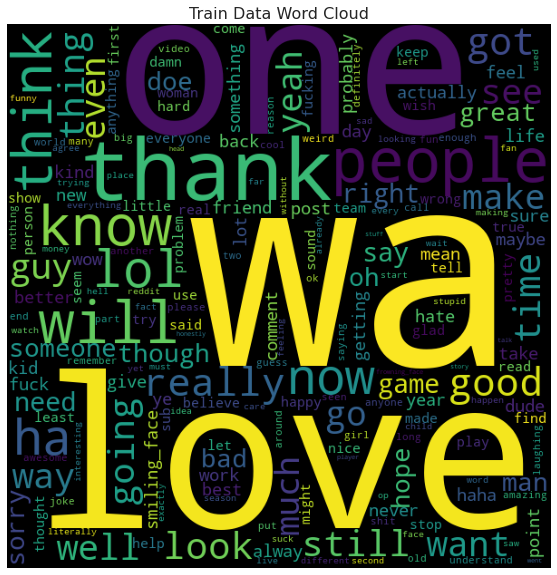

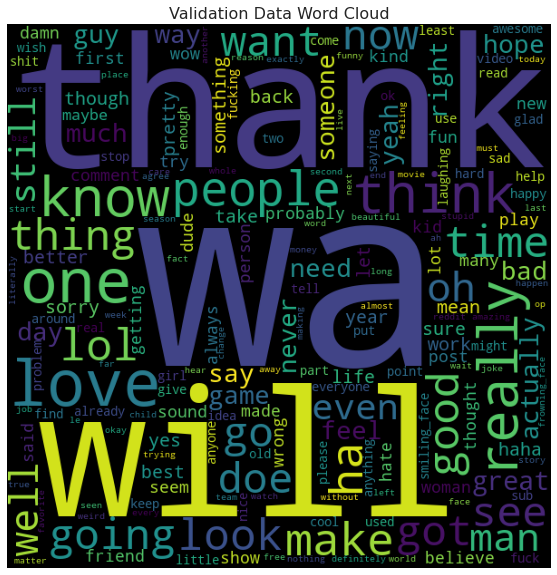

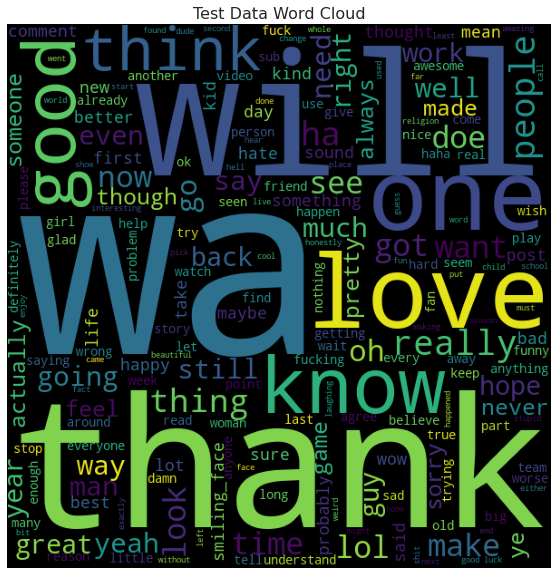

In [ ]:
data = {'Train Data': train_GE, 'Validation Data': val_GE, 'Test Data': test_GE}

def plot_cloud(wordcloud, temp):
    plt.figure(figsize=(10, 10))
    plt.title(temp+' Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");

for temp in data:
    temp_text = ' '.join([sentence for sentence in data[temp].Clean_text])
    wordcloud = WordCloud(width = 600, height = 600).generate(temp_text)
    plot_cloud(wordcloud, temp)

In [ ]:
def plot_top_words_barchart(comments, axes):
  comments = comments.str.split() # split each comment into a list of words
  comments = comments.values.tolist() # from pandas series to lists of words
  corpus = [word for sample in comments for word in sample if word not in list(STOP_WORDS)+["?","!","name"]] # giant corpus of words excluding special characters
  counter = Counter(corpus) # create a counter
  most = counter.most_common(10) # retrieve the 10 most frequent words
  # Plot the 10 top words and their frequencies
  most = [(word, count) for (word, count) in most]
  x, y = [], []
  for word, count in most[:10]:
    x.append(word)
    y.append(count)
    sns.barplot(x=y, y=x , ax=axes, palette="Set2")

In [ ]:
# Displaying 10 most frequent words for each emotion
fig, axes = plt.subplots(7, 4, figsize=(25, 30))
fig.suptitle('10 most frequent words for each emotion', fontweight="bold", fontsize=20)

for i, axi in enumerate(axes.flat):
    plot_top_words_barchart(train_GE.loc[train_GE[Lable_names[i]]==1,"Clean_text"], axi)
    axi.set_title(Lable_names[i], fontweight="bold")

plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
# Droping unecessary columns
train_GE = train_GE[ ['Clean_text'] + Lable_names ]

# Saving datasets for modeling
train_GE.to_csv("/content/drive/MyDrive/Colab Notebooks/Data/train_clean.csv", index = False)
val_GE.to_csv("/content/drive/MyDrive/Colab Notebooks/Data/val_clean.csv", index = False)
test_GE.to_csv("/content/drive/MyDrive/Colab Notebooks/Data/test_clean.csv", index = False)